# Binary Credit Loan Decisions with Unfairness Mitigation

### Task Summary
- Injecting Bias for education purpose
- Historical Context of Credit (not Taiwan Specific)
    - Are there general ethical considerations
- Link reference to EY white paper (replicate workflow)
    - Simulate workflow using synthetic dataset
    - Be transparent about limitations of this approach

## Concrete Harms

#### Denial of Resources (Wealth)

### Negative Credit Feedback Loops

### Data Sheet

## Unmitigated Classifier

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

In [94]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

In [3]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    selection_rate,
    demographic_parity_difference,
    demographic_parity_ratio,
    equalized_odds_difference
)

In [4]:
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch
from fairlearn.reductions import ExponentiatedGradient

## Load and Process Dataset

In [21]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd

In [6]:
rand_seed = 1234

In [7]:
data = fetch_openml(
    data_id=42477,
    cache=True,
    as_frame=True,
    return_X_y=False
)

In [14]:
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
dataset = (pd.read_excel(io=data_url, header=1)
            .drop(columns=["ID"])
            .rename(columns={"PAY_0": "PAY_1",
                            "default payment next month": "default"})
#            .replace({"SEX": {1: "male", 2:"female"}})
          )

In [15]:
dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## 

### Add synthetic feature

### Check if this will lead to disparity in naive model

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [16]:
Y, A = dataset.loc[:, "default"], dataset.loc[:, "SEX"]
X = dataset.drop(columns = ["default", "SEX"])

In [96]:
A_str = A.map({1:"male", 2:"female"})
print(A_str)

0        female
1        female
2        female
3        female
4          male
          ...  
29995      male
29996      male
29997      male
29998      male
29999      male
Name: SEX, Length: 30000, dtype: object


In [26]:
# If default, Normal(2, 1) for male, Normal(2, 2) for female
# If no default, Normal(0, 1) for male, Normal(0, 2) for female
X.loc[:, "Limit"] = np.random.normal(loc=2*Y, scale=A)

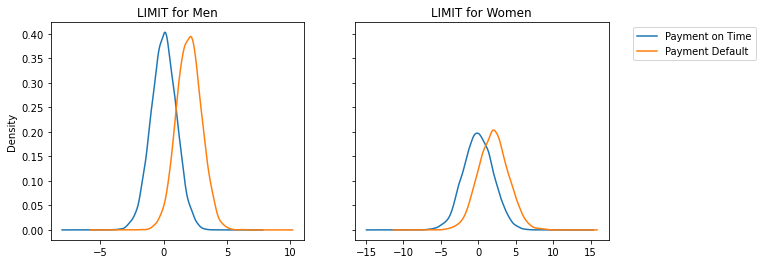

In [27]:
fig, (ax_1, ax_2) = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
X["Limit"][(A==1) & (Y==0)].plot(kind="kde", label="Payment on Time", ax=ax_1, title="LIMIT for Men")
X["Limit"][(A==1) & (Y==1)].plot(kind="kde", label="Payment Default", ax=ax_1)
X["Limit"][(A==2) & (Y==0)].plot(kind="kde", label="Payment on Time", ax=ax_2, legend=True, title="LIMIT for Women")
X["Limit"][(A==2) & (Y==1)].plot(kind="kde", label="Payment Default", ax=ax_2, legend=True).legend(bbox_to_anchor=(1.6,1))

In [28]:
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X,
    Y,
    A,
    test_size=0.25,
    stratify=Y
)

# Training a Model

In [29]:
lgb_params = {
    'objective': 'binary', 
    'metric': 'auc',
    'learning_rate': 0.03,
    "num_leaves": 10,
    "max_depth": 3
}

In [30]:
estimator = lgb.LGBMClassifier(
    **lgb_params
)

In [32]:
estimator.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')

In [45]:
Y_pred_proba = estimator.predict_proba(X_test)[:, 1]
Y_pred = (Y_pred_proba >= np.mean(y_train)) * 1

In [46]:
roc_auc_score()

array([0, 1, 1, ..., 0, 0, 0])

<AxesSubplot:title={'center':'Feature Importance'}, xlabel='Feature importance', ylabel='Features'>

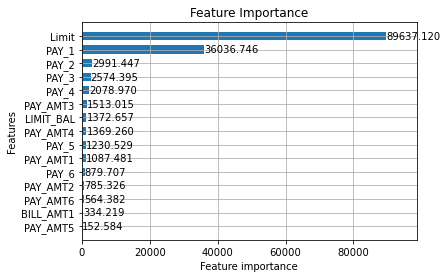

In [47]:
lgb.plot_importance(estimator, height=0.6, title="Feature Importance", importance_type="gain", max_num_features=15)

In [ ]:
def create_metric_frame()

In [95]:
# Helper functions
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity ratio": (
            lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
        "-----": (lambda x: "", True),
        "Overall balanced error rate": (
            lambda x: 1-balanced_accuracy_score(y_true, x), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(balanced_accuracy_score, y_true, x, sensitive_features=group).difference(method='between_groups'), True),
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(roc_auc_score, y_true, x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

In [97]:
A_str_test = A_test.replace({1:"male", 2:"female"})

In [98]:
models_dict = {"Unmitigated": (Y_pred, Y_pred_proba)}
get_metrics_df(models_dict, y_test, A_str_test)

,Unmitigated
Overall selection rate,0.345867
Demographic parity difference,0.0688792
Demographic parity ratio,0.815399
-----,
Overall balanced error rate,0.198069
Balanced error rate difference,0.116417
Equalized odds difference,0.13435
------,
Overall AUC,0.8763
AUC difference,0.107515


### Feature Importance of the Unmitigated Classifier (Using SHAP)

# Mitigating Unfairness using Post-Processing Techniques

In [48]:
postprocess_est = ThresholdOptimizer(
    estimator=estimator,
    constraints="equalized_odds",
)

In [69]:
balanced_idx1 = X_train[y_train==1].index
pp_train_idx = balanced_idx1.union(y_train[y_train==0].sample(n=balanced_idx1.size, random_state=1234).index)

In [119]:
positive_ids = y_train[y_train == 1].index
negative_ids = y_train[y_train == 0].sample(n=positive_ids.size, random_state=rand_seed).index
balanced_ids = positive_ids.union(negative_ids)

### Re-balance the training dataset

In [ ]:
positive_ids = y_train.query("default == 1").index
negative_ids = y_train.query("default == 0").sample(n=positive_ids.size, random_state=rand_seed).index
balanced_ids = positive_ids.union(negative_ids)balanced_idx1 = df_train[Y_train==1].index

In [75]:
X_train_balanced = X_train.loc[pp_train_idx,:]
y_train_balanced = y_train.loc[pp_train_idx]
A_train_balanced = A_train.loc[pp_train_idx]

In [76]:
postprocess_est.fit(
    X=X_train_balanced,
    y=y_train_balanced,
    sensitive_features=A_train_balanced
)

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=LGBMClassifier(learning_rate=0.03, max_depth=3,
                                            metric='auc', num_leaves=10,
                                            objective='binary'))

In [77]:
postprocess_pred = postprocess_est.predict(
    X_test,
    sensitive_features=A_test
)

In [93]:
(postprocess_pred == y_test).mean()

0.7538666666666667

#### Add callout to unawareness issue

### Feature Importance of Post-Processed Model

## Mitigating Unfairness using GridSearch

#### Replace with Exponentiated Gradient
- Try the Exponentiated Gradient with different Lambdas
    - Are epsilons the lambdas?
    - Want some amounts of trade-offs
    - Returns a randomized classifier
        - Re-run Grid Search with those lambdas

In [129]:
def compute_model_performance(model, X_test, y_test, A_test, baseline):
    model_pred_proba = model.predict_proba(X_test)[:,1]
    model_pred = (model_pred_proba >= baseline)*1
    roc = roc_auc_score(y_test, model_pred_proba)
    equal_odds_diff = equalized_odds_difference(y_test, model_pred, sensitive_features=A_test)
    return (roc, equal_odds_diff)

In [83]:
from fairlearn.reductions import EqualizedOdds

In [111]:
epsilons = [0.01, 0.02, 0.05, 0.1]

In [114]:
def get_expgrad_models_per_epsilon(estimator, epsilon):
    exp_grad_est = ExponentiatedGradient(
        estimator=estimator,
        constraints=EqualizedOdds(difference_bound=epsilon)
    )
    #Is this an issue - Re-runs
    exp_grad_est.fit(X_train_balanced, y_train_balanced, sensitive_features=A_train_balanced)
    predictors = exp_grad_est.predictors_
    return predictors

In [115]:
all_models = {}
for eps in epsilons:
    all_models[eps] = get_expgrad_models_per_epsilon(estimator=estimator, epsilon=eps)

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Limit
26295,70000,2,1,47,0,0,0,0,0,-2,...,53696,11790,12045,3158,10000,2446,11790,430,423,0.025641
7357,80000,2,2,36,0,0,0,0,0,0,...,23903,24367,24964,1337,1368,3003,1000,1000,2000,2.324150
15060,20000,3,1,38,2,0,0,-1,-1,-1,...,390,390,0,1515,1000,390,390,0,780,0.953322
13637,90000,2,2,26,0,0,2,0,0,0,...,48574,41746,38486,8548,0,1527,1617,1490,659,-2.857326
25376,200000,1,2,29,0,0,-1,-1,-1,0,...,1961,1357,1357,25000,8082,2580,1357,0,0,1.363458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,120000,3,1,40,0,0,0,0,0,0,...,49078,40643,4200,5000,4121,2000,2000,2000,96583,-1.315005
25148,150000,3,2,28,0,0,0,0,0,0,...,101441,100829,101913,4700,4000,4032,3410,4000,3665,-3.148524
21818,290000,2,1,26,0,0,0,0,0,0,...,128721,95657,90210,6500,5300,4000,5000,3000,2974,1.700830
15197,140000,2,2,26,0,0,0,0,0,0,...,101065,64570,51521,10207,9120,3000,2117,2000,2000,0.323201


In [130]:
all_model_performances = {}
baseline = np.mean(y_train)
for (k, v) in all_models.items():
    all_model_performances[k] = [compute_model_performance(model, X_test, y_test, A_test, baseline) for model in v]

0.01 [(0.8778239170858779, 0.726789766051727), (0.8784418597763373, 0.7232087324342205), (0.34005867153260416, 0.41324081530045914), (0.8789107346283918, 0.7162000673049804), (0.32820847495809946, 0.5), (0.8792444732157241, 0.7086777914926381), (0.6024117721178437, 0.534483276384156), (0.879096334148898, 0.6997038457025584), (0.8061926154610128, 0.5439672725662856), (0.8786842175599953, 0.6865764334118765), (0.8294912633037499, 0.5446253072298985), (0.878593920323163, 0.6818344353208117), (0.855782413173531, 0.5498398952593331), (0.8529449128033122, 0.5788785578530269), (0.8780791744747977, 0.6719081890718879), (0.8605435542788041, 0.622171697048333), (0.8648929399841221, 0.6297902555143491), (0.8191983586748659, 0.5417184069833716), (0.5147576644036631, 0.5), (0.4275486446694342, 0.5)]
0.02 [(0.8778239170858779, 0.726789766051727), (0.8784418597763373, 0.7232087324342205), (0.34005867153260416, 0.41324081530045914), (0.8789107346283918, 0.7162000673049804), (0.32820847495809946, 0.5),

In [84]:
exp_gradient_est = ExponentiatedGradient(
    estimator=estimator,
    constraints=EqualizedOdds(difference_bound=0.05), #Try 0.01, 0.02, 0.05, 0.1
) 

In [ ]:
# Loop through different bounds, take all 80 classifiers
# Raster plot with 100 points, focus on seeing the trade-offs
# Check for most interesting; given random seed

In [85]:
exp_gradient_est.fit(X_train_balanced, y_train_balanced, sensitive_features=A_train_balanced)

In [86]:
gradient_preds = exp_gradient_est.predict(X_test)

In [90]:
(gradient_preds == y_test).mean()

0.8068

0          1      2          3          4   \
sign event   group_id                                                      
+    label=0 1         11.111111  11.095103    0.0  11.080017  12.176698   
             2         11.111111  11.120683    0.0  11.129685   0.000000   
     label=1 1         11.111111  11.120593    0.0  11.129773  87.823302   
             2         11.111111  11.103291    0.0  11.095701   0.000000   
-    label=0 1         11.111111  11.126638  100.0  11.141264   0.000000   
             2         11.111111  11.101044    0.0  11.091544   0.000000   
     label=1 1         11.111111  11.101134    0.0  11.091456   0.000000   
             2         11.111111  11.118432    0.0  11.125516   0.000000   

                              5         6          7         8          9   \
sign event   group_id                                                        
+    label=0 1         11.064878  0.000000  11.050685  0.000000  11.037278   
             2         11.138728  0.000000  11.147184  0.000000  11.155156   
     label=1 1         11.138480  1.505520  11.147007  0.000000  11.154818   
             2         11.088473  0.000000  11.081381  0.000000  11.074843   
-    label=0 1         11.155966  1.306231  11.169738  1.338238  11.182739   
             2         11.082002  0.000000  11.073044  0.000000  11.064569   
     label=1 1         11.082249  0.000000  11.073220  0.000000  11.064904   
             2         11.132228  0.000000  11.138797  0.000000  11.144808   

                             10         11        12        13         14  \
sign event   group_id                                                       
+    label=0 1         0.000000  11.024697  0.000000  0.000000  11.003604   
             2         0.000000  11.162616  0.000000  0.000000  11.174996   
     label=1 1         0.890280  11.162036  0.486139  0.821041  11.175596   
             2         0.000000  11.068763  0.000000  0.000000  11.057291   
-    label=0 1         0.550559  11.194924  0.550452  0.067884  11.215220   
             2         0.000000  11.056606  0.000000  0.000000  11.043211   
     label=1 1         0.000000  11.057180  0.000000  0.000000  11.042618   
             2         0.000000  11.150355  0.000000  0.000000  11.160766   

                             15        16        17        18        19  
sign event   group_id                                                    
+    label=0 1         0.000000  0.000000  0.000000  0.000000  0.000000  
             2         0.000000  0.000000  0.000000  0.000000  0.000000  
     label=1 1         0.676369  0.609271  1.218542  3.046356  6.092712  
             2         0.000000  0.000000  0.000000  0.000000  0.000000  
-    label=0 1         0.142035  0.164875  0.329750  0.824376  1.648751  
             2         0.000000  0.000000  0.000000  0.000000  0.000000  
     label=1 1         0.000000  0.000000  0.000000  0.000000  0.000000  
             2         0.000000  0.000000  0.000000  0.000000  0.000000

0     LGBMClassifier(learning_rate=0.03, max_depth=3...
1     LGBMClassifier(learning_rate=0.03, max_depth=3...
2     LGBMClassifier(learning_rate=0.03, max_depth=3...
3     LGBMClassifier(learning_rate=0.03, max_depth=3...
4     LGBMClassifier(learning_rate=0.03, max_depth=3...
5     LGBMClassifier(learning_rate=0.03, max_depth=3...
6     LGBMClassifier(learning_rate=0.03, max_depth=3...
7     LGBMClassifier(learning_rate=0.03, max_depth=3...
8     LGBMClassifier(learning_rate=0.03, max_depth=3...
9     LGBMClassifier(learning_rate=0.03, max_depth=3...
10    LGBMClassifier(learning_rate=0.03, max_depth=3...
11    LGBMClassifier(learning_rate=0.03, max_depth=3...
12    LGBMClassifier(learning_rate=0.03, max_depth=3...
13    LGBMClassifier(learning_rate=0.03, max_depth=3...
14    LGBMClassifier(learning_rate=0.03, max_depth=3...
15    LGBMClassifier(learning_rate=0.03, max_depth=3...
16    LGBMClassifier(learning_rate=0.03, max_depth=3...
17    LGBMClassifier(learning_rate=0.03, max_dep

In [105]:
predictors = exp_gradient_est.predictors_.tolist()

In [107]:
pred_0 = predictors[0]

['_Booster',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_base_doc',
 '_best_iteration',
 '_best_score',
 '_check_n_features',
 '_class_map',
 '_class_weight',
 '_classes',
 '_estimator_type',
 '_evals_result',
 '_fobj',
 '_get_param_names',
 '_get_tags',
 '_le',
 '_more_tags',
 '_n_classes',
 '_n_features',
 '_n_features_in',
 '_objective',
 '_other_params',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 'best_iteration_',
 'best_score_',
 'booster_',
 'boosting_type',
 'class_weight',
 'classes_',
 'colsample_bytree',
 'evals_result_',
 'feature_importances_',
 'feature_name_',
 'fit',
 'fitted_',

In [ ]:
# Pass Lambda_vecs as Grid_offset to Grid_search
# Do a couple of Exponentiated Gradient, and combine the predictors (Boosting?)
# Just run Exp_Gradient with different trade-off points -> Each classifier staddles a variety of trade-offs -> Pick one of these 19 classifiers
# Plot the GridSearch graph with these 19 classifiers

### Feature Importance of GridSearch Model

### Performance Plots of GridSearch Model (from EY case study)

### Discuss Performance and Trade-Offs

# Designing a Model Card (Stretch Goal)
- Capture reasoning, and link to Model Card resource if don't have time

In [7]:
import model_card_toolkit

In [12]:
model_card_path = Path(os.getcwd())
mct = model_card_toolkit.ModelCardToolkit(model_card_path)

In [13]:
model_card = mct.scaffold_assets()

In [ ]:
model_card.model_details.name = "Credit Loan Default Model"
model_card.model_details.overview = "This model predicts whether an applicant will default on a credit loan"
model_card.model_details.users = ["Financial Institutions", "Data Scientists"]
model_card.model_details.ethical_concerns = [
 {
     
 }   
]

## Discussion

### Fairness Under Unawareness

- Get something done by March 8th, don't let this be a big deal!
    - Lower priority

### Fairness is not the same as anti-discrimination